## Chapter 2-5, 1강 STT(음성→텍스트) 기초와 데이터 핸들링 — Whisper 실습

- 목표: 음성→텍스트(STT) 기본 개념과 워크플로우 이해, Whisper로 전사 및 정확도(WER) 측정
- 데이터: 짧은 음성-텍스트 pair 샘플(예: Common Voice ko 소규모 발화, 또는 제공된 예제 파일)
- 규칙(강의용): 시각화는 `matplotlib`만 사용, 불필요한 외부 의존 최소화


### 구성 (Overview)
1) **STT 개요 & 워크플로우**
   - Whisper 핵심 개념, 모델 크기별 특징, 디코딩(temperature/beam) 개요

2) **환경 준비**
   - `ffmpeg` 확인, 라이브러리 설치/임포트, 한글 폰트 & 경고 억제 설정, `DEVICE`(CPU/GPU) 출력

3) **데이터 준비**
   - 오디오 로딩 유틸: 16kHz 리샘플 · 모노 변환 · 구간 추출(`load_audio_mono_16k`)

4) **Whisper 전사 데모**
   - 모델 선택(`tiny`, `base`, `small`), 언어 지정(`language='ko'` 등)  
   - 짧은 파일 전사 기본 흐름(`transcribe_with_whisper`)

5) **정확도 지표 (참고)**
   - **WER/CER 동시 계산**: 정규화 원칙(단어/문자 단위) 문서화  
   - `compute_error_rates()`로 `(CER, WER)` 반환

6) **모델 크기 · 속도 · 품질 벤치마크**
   - 동일 10–15초 샘플로 `tiny/base/small` 비교  
   - 실행 시간, 텍스트 요약, (선택) CER/WER → `run_whisper_once`, `benchmark_whisper_models`

7) **디코딩 파라미터 실험**
   - `transcribe_with_params`: `temperature`, `beam_size`, `best_of` 조합 A/B 테스트

8) **긴 오디오 전사 (슬라이딩 윈도우)**
   - `transcribe_sliding(win_sec, hop_sec)`로 긴 MP3/WAV 처리  
   - 결과: 전체 텍스트, 세그먼트, 윈도우 요약

9) **시각화 & 에러 분석**
   - 파형 + 세그먼트 오버레이: `plot_wave_and_segments`  
   - 레퍼런스 vs 예측 **diff(삽입/삭제/치환)**: `diff_tokens`




### 데이터 소스 (Short & Long)

**1) 단문(Short) — KSS Dataset**  
- 출처: *Korean Single Speaker Speech (KSS)*  
- 문장 레퍼런스: `transcript.v.1.4.txt` (각 발화에 대한 텍스트가 정렬되어 있음)  
- 사용법: 짧은 문장 전사 실습 및 WER/CER 평가용 레퍼런스 텍스트로 활용

> 참고 링크  
> - Kaggle: Korean Single Speaker Speech Dataset (KSS)  
>   https://www.kaggle.com/datasets/bryanpark/korean-single-speaker-speech-dataset  
>   (데이터 탭에서 `transcript.v.1.4.txt` 확인)

---

**2) 장문(Long) — 비타민 한국어 오디오 (Darakwon)**  
- 출처: 다락원(Darakwon) 교재 부록 **무료 MP3 오디오**  
- 사용법: 1–2분 길이의 대화 트랙을 **슬라이딩 윈도우 전사** 데모에 활용

> 참고 링크  
> - 비타민 한국어 4 MP3 다운로드(다락원)  
>   https://www.darakwon.co.kr/mp3/FileDown_kor2.asp?p_id=6772&pf_type=5  

---

#### 운영 팁
- **라이선스/이용 범위**: 교육·연구 목적 사용 시에도 각 페이지의 이용 조건을 확인하세요.  
- **전처리**: Whisper 입력 표준(모노/16kHz)에 맞게 변환 → `load_audio_mono_16k()` 또는 `ffmpeg`로 리샘플링  
- **예제 경로 변수**  
  - 단문 예제(WAV): `EXAMPLE_WAV = "./data/speech/1_0001.wav"`  
  - 장문 예제(MP3): `EXAMPLE_MP3 = "./data/speech/Vitamin4_002_1-1.mp3"` (실제 다운로드 파일명/경로에 맞게 수정)  


In [1]:
import shutil

def check_ffmpeg():
    """
    ffmpeg 설치 여부를 확인하는 함수.
    - Whisper는 오디오 처리에 ffmpeg를 필요로 하는 경우가 많음.
    - 미디어 변환/처리 도구로 사용하며 거의 모든 오디오·비디오 포맷을 디코딩/인코딩하고, 자르기/병합/리샘플/채널변환/볼륨조정 등을 수행.
    - 본 과정에서의 역할
        . mp3/wav 등 다양한 포맷을 Whisper가 읽을 수 있게 디코딩.
        . STT 학습/추론에 맞게 16kHz·모노로 리샘플/다운믹스해 tmp_16k.wav 생성.
        . 긴 파일 일부 구간만 추출(시간 오프셋/길이) 등 전처리.
    - 설치 여부 확인 후 경로를 출력, 없으면 설치 방법 안내.
    """
    path = shutil.which('ffmpeg')
    print('ffmpeg:', path or '미설치 — macOS: brew install ffmpeg / Windows: choco install ffmpeg 또는 scoop install ffmpeg')


# ffmpeg 확인 실행
check_ffmpeg()

ffmpeg: /usr/local/bin/ffmpeg


### 0. 환경 준비 및 라이브러리 임포트

- 시각화는 `matplotlib`만 사용합니다.
- STT는 `openai-whisper`, 오디오 I/O/변환은 `torchaudio`, 평가는 `jiwer`를 사용합니다.
- 한글 폰트와 경고 억제를 설정합니다.



In [2]:
# -*- coding: utf-8 -*-
# UTF-8 인코딩 설정 (한글 등 다국어 문자 처리를 위해 사용)

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Dict, List, Tuple, Optional

import torch
import torchaudio

warnings.filterwarnings("ignore", message="FP16 is not supported on CPU; using FP32 instead")


# Whisper(OpenAI 음성 인식 라이브러리) 사용 가능 여부 확인
try:
    import whisper
    _HAS_WHISPER = True
except Exception:
    _HAS_WHISPER = False

# jiwer(WER: Word Error Rate 계산용 라이브러리) 사용 가능 여부 확인
try:
    import jiwer
    _HAS_JIWER = True
except Exception:
    _HAS_JIWER = False

# 경고 메시지 무시 설정
warnings.filterwarnings("ignore", category=FutureWarning)  # 미래 버전 관련 경고 무시
warnings.filterwarnings("ignore", category=DeprecationWarning)  # 폐지 예정 기능 경고 무시
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)  # 폰트 관련 경고 무시

# Matplotlib 그래프 한글 폰트 설정 및 마이너스 기호 깨짐 방지
plt.rcParams['font.family'] = 'AppleGothic'   # macOS용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False    # 음수(-) 기호가 깨지지 않도록 설정

# PyTorch에서 사용할 디바이스 설정 (GPU 사용 가능하면 cuda, 아니면 cpu)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)



Device: cpu


### 1. Whisper 모델 개요
**Whisper는 OpenAI 연구팀이 22년 9울 21일에 공개한 전세계 다양한 언어를 안정적으로 인식하고 번역까지 가능한 범용 음성 인식 모델**  


#### 주요 특징
- **다국어 지원**: 97개 이상의 언어 음성을 텍스트로 변환 가능  
- **번역 기능**: 한국어 음성을 영어 텍스트로 번역 같은 cross-lingual 기능 지원  
- **대규모 학습 데이터**: 68만 시간 이상의 웹 음성 데이터로 학습 → 노이즈/억양에도 강함  
- **세그먼트 타임스탬프**: 전사 결과에 시작/끝 시간이 포함되어 자막 생성 가능  

---

#### 모델 크기별 버전
Whisper는 여러 크기의 모델이 제공됩니다. (속도 ↔ 정확도 트레이드오프)

| 모델 | 파라미터 수 | 상대 속도 | 특징 |
|---|---|---|---|
| **tiny**   | 39M   | 가장 빠름 | 리소스 적음, 정확도 낮음 |
| **base**   | 74M   | 빠름 | CPU 실습 적합 |
| **small**  | 244M  | 중간 | 정확도 향상 |
| **medium** | 769M  | 느림 | 더 높은 정확도 |
| **large**  | 1550M | 가장 느림 | 최고 정확도, GPU 권장 |

**CPU 실습**: tiny / base 권장  
**GPU 사용**: small 이상 가능  

---

#### 장단점
**장점**
- 범용 다국어 모델 (하나로 여러 언어 처리 가능)  
- 잡음, 억양, 사투리에 강인함  
- 오픈소스로 무료 사용 가능  

**단점**
- 큰 모델은 CPU에서 매우 느림  
- large 모델은 메모리 사용량이 큼  
- 실시간보다는 “파일 단위 배치 처리”에 더 적합  

---

#### 활용 예시
- 회의/강의 자동 자막 생성  
- 유튜브/팟캐스트 스크립트 추출  
- 다국어 영상의 영어 번역 자막 생성  
- 고객센터 통화 분석  




In [3]:
# CPU 최적화: 단일 모델 로드 + 그리디 디코딩
DEFAULT_MODEL_CPU = 'tiny'     # CPU 환경에서 사용할 Whisper 모델 (가장 작은 모델, 속도 우선)
_DEFAULT_MODEL_GPU = 'base'    # GPU 환경에서 사용할 Whisper 모델 (조금 더 큰 모델, 성능 우선)
_MODEL_SINGLETON = None        # Whisper 모델을 단 한 번만 로드해 재사용하기 위한 전역 변수

# Whisper 모델 로드 (환경에 따라 tiny 또는 base 모델 선택)
if _HAS_WHISPER:
    try:
        # CPU면 tiny, GPU면 base 모델 로드
        model_name = DEFAULT_MODEL_CPU if DEVICE == 'cpu' else _DEFAULT_MODEL_GPU
        _MODEL_SINGLETON = whisper.load_model(model_name, device=DEVICE)
        print('Whisper 모델 로드 성공:', model_name)
    except Exception as e:
        # 모델 로드 실패 시 None으로 설정
        _MODEL_SINGLETON = None
        print('Whisper 모델 로드 실패:', e)


Whisper 모델 로드 성공: tiny


In [4]:

# 빠른 음성 -> 텍스트 변환 함수 정의
def fast_transcribe(path: str, language: str = 'ko'):
    """
    Whisper를 이용해 음성 파일을 빠르게 텍스트로 변환하는 함수.
    - 단일 모델 싱글톤을 활용해 불필요한 로드 방지
    - Greedy decoding 방식(beam_size=1)으로 속도 최적화
    - temperature=0.0 → 결과의 일관성 강화
    - fp16=False → CPU 환경에서도 문제없이 동작 가능
    """
    if not _HAS_WHISPER or _MODEL_SINGLETON is None:
        raise ImportError('whisper 모델을 사용할 수 없습니다. 설치 또는 로드 오류를 확인하세요.')
    
    return _MODEL_SINGLETON.transcribe(
        path,                 # 입력 오디오 파일 경로
        language=language,    # 언어 (기본값: 한국어 'ko')
        temperature=0.0,      # 탐색 무작위성 제거 (결과 일관성 ↑)
        beam_size=1,          # beam search 대신 greedy decoding 사용 (속도 ↑)
        # 1.Greedy decoding (beam_size = 1)
        #매 스텝마다 가장 확률이 높은 토큰 하나만 선택
        #속도 빠름, 메모리 적게 사용
        #하지만 최적(global optimum)이 아닌 **국소적 최적(local optimum)**에 갇힐 수 있음 → 문장 품질 떨어질 수 있음

        # 2. Beam search (beam_size > 1)
        # 매 스텝마다 여러 후보 토큰을 유지하면서 탐색
        # beam_size = 유지할 후보 개수
        # 더 많은 후보를 고려하므로 정확도 향상 가능
        # 하지만 속도 느려짐 + 메모리 사용 증가

        # 예시
        # 문장을 “오늘 날씨가 좋다”라고 할 때
        # beam_size=1 (greedy)
        # → 오늘 날씨 좋다 (중간에 “가”를 빼먹음)
        # beam_size=5
        # → 후보 여러 개를 탐색하다가
        # → 오늘 날씨가 좋다 (더 자연스러운 문장 선택)

        best_of=None,         # 후보 중 최적 선택 기능 비활성화 (속도 ↑)
        fp16=False            # half-precision 비활성화 (CPU 호환성 ↑)
    )


### 2. 데이터 준비 및 전처리
- 예제 오디오 파일 경로 지정, 로드, 16kHz 리샘플, 모노 변환
- 긴 파일은 일부 구간만 사용(강의 시간 고려, 10–15초 권장)



In [5]:
def load_audio_mono_16k(path: str, offset_sec: float = 0.0, duration_sec: float | None = None):
    """
    오디오 파일을 로드하여 16kHz 모노 신호로 변환합니다.
    - offset_sec: 시작 지점(초) → 이 시점부터 오디오를 잘라 사용
    - duration_sec: 길이(초) → 지정 시 offset부터 duration 길이만큼 잘라서 반환
    """

    # 파일 존재 여부 확인
    if not os.path.exists(path):
        raise FileNotFoundError('오디오 파일을 찾을 수 없습니다: ' + path)

    # 오디오 로드 (torchaudio는 (채널, 시간) 형태 반환)
    wav, sr = torchaudio.load(path)

    # 모노 변환: 채널이 여러 개(스테레오 등)라면 평균 내어 하나의 채널로 변환
    if wav.size(0) > 1:
        wav = wav.mean(dim=0, keepdim=True)

    # 샘플링 레이트 변환 (16kHz로 통일)
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
        wav = resampler(wav)
        sr = 16000

    # offset과 duration 적용 (특정 구간만 잘라내기)
    if offset_sec > 0 or duration_sec is not None:
        start = int(offset_sec * sr)  # 시작 위치 (샘플 단위)
        end = start + int(duration_sec * sr) if duration_sec is not None else wav.size(1)
        wav = wav[:, start:end]

    # (time,) 형태로 변환해서 반환 (채널 제거) + 샘플링 레이트(16k)
    return wav.squeeze(0), sr


# -------------------------------
# 예시 경로 (수강생은 직접 자신의 음성 파일로 교체 가능)
EXAMPLE_WAV = './data/speech/1_0001.wav'




### 3. Whisper 전사 데모
- Whisper 모델(`tiny`, `base`, `small`) 중 선택 가능  
- 언어 지정(`ko`, `en`, …), CPU/GPU 자동 감지 후 동작  
- 긴 오디오 파일은 전체 한 번에 처리하기 어렵기 때문에 **부분 전사** 또는 **슬라이딩 윈도우** 전략 사용 권장  
- 여기서는 짧은 15초 구간을 잘라서 전사 시연  


In [12]:
def transcribe_with_whisper(path: str, model_name: str = 'base', language: str | None = None):
    """
    Whisper 모델을 이용해 음성을 텍스트로 전사하는 함수
    - path: 오디오 파일 경로 (.wav)
    - model_name: 사용할 Whisper 모델 이름 (tiny, base, small, medium, large 등)
    - language: 언어 코드 ('ko', 'en' 등). None이면 자동 감지
    """
    if not _HAS_WHISPER:
        raise ImportError(
            'whisper 패키지가 설치되어 있지 않습니다. 설치: pip install -U openai-whisper'
        )

    # Whisper는 내부적으로 ffmpeg를 사용 → ffmpeg 설치 필요
    model = whisper.load_model(model_name, device=DEVICE)

    # Whisper 내장 transcribe() 사용 (자동 리샘플링/패딩 포함)
    result = model.transcribe(path, language=language)
    return result


# -------------------------------
# 데모 실행 (예시)
try:
    # 예제 wav 파일에서 앞 15초만 불러오기
    wav, sr = load_audio_mono_16k(EXAMPLE_WAV, duration_sec=15)

    # Whisper는 파일 경로 입력을 받기 때문에, 임시 wav 파일로 저장
    tmp_path = './data/speech/tmp_16k.wav'
    torchaudio.save(tmp_path, wav.unsqueeze(0), 16000)

    # 전사 실행 (base 모델, 한국어 지정)
    out = transcribe_with_whisper(tmp_path, model_name='base', language='ko')

    # 전사 결과 출력 (앞부분 120자만 확인)
    print('전사 결과:', out['text'][:120], '...')

except Exception as e:
    print('데모 실행 중 문제:', e)



전사 결과:  그녀의 사랑을 얻기 위해 애써지만 호수고였다. ...


### 4. 정확도 평가 (WER/CER) — 참고용
- **전제:** 레퍼런스 텍스트가 있을 때만 사용하세요.
- **정규화 원칙**
  - **WER(단어 단위)**: 공백은 **토큰 경계**이므로 유지합니다. ⇒ 소문자화, 다중 공백 정리, 앞뒤 공백 제거(필요 시 문장부호 제거).
  - **CER(문자 단위)**: 한국어는 띄어쓰기 변동의 영향이 커서 **공백을 제거**하고 비교하는 편이 일반적입니다(필요 시 문장부호 제거).
- **권장사항:** 실험/서비스마다 “무엇을 품질로 볼 것인가”를 문서화하고, 동일한 정규화 절차를 **일관되게 적용**하세요.


In [7]:
def compute_error_rates(hypothesis: str, reference: str):
    """
    정규화 후 CER, WER를 함께 계산해 (cer, wer)로 반환합니다.

    - WER: 단어 단위 평가 → 공백은 토큰 경계이므로 '유지'
      · 적용: 소문자화, 다중 공백 정리, 앞뒤 공백 제거
      · 선택: 문장부호 제거(RemovePunctuation) — 과도한 정규화에 주의

    - CER: 문자 단위 평가 → 공백 자체가 오류율에 왜곡을 줄 수 있어 '제거'
      · 적용: 다중 공백 정리, 앞뒤 공백 제거, 이후 공백 삭제(replace)
      · 선택: 문장부호 제거(RemovePunctuation)

    주의: 정규화 스펙은 실험 목적에 따라 달라질 수 있습니다.
         반드시 문서화하여 팀 내/실험 간 일관성을 유지하세요.
    """
    if not _HAS_JIWER:
        raise ImportError('jiwer 필요')

    # -----------------------------
    # 1) WER용 정규화: 공백 '유지'
    # -----------------------------
    norm_w = jiwer.Compose([
        jiwer.ToLowerCase(),         # 대소문자 통일
        jiwer.RemoveMultipleSpaces(),# 다중 공백을 단일 공백으로
        jiwer.Strip(),               # 앞/뒤 공백 제거
        # jiwer.RemovePunctuation(), # 필요 시 활성화 (과정 문서화 필수)
    ])
    ref_w = norm_w(reference)
    hyp_w = norm_w(hypothesis)

    # -----------------------------
    # 2) CER용 정규화: 공백 '제거'
    # -----------------------------
    norm_c = jiwer.Compose([
        jiwer.RemoveMultipleSpaces(),# 다중 공백 정리
        jiwer.Strip(),               # 앞/뒤 공백 제거
        # jiwer.RemovePunctuation(), # 필요 시 활성화 (과정 문서화 필수)
    ])
    # 문자 단위 비교를 위해 공백 자체 제거
    ref_c = norm_c(reference).replace(" ", "")
    hyp_c = norm_c(hypothesis).replace(" ", "")

    # -----------------------------
    # 3) 지표 계산
    # -----------------------------
    wer = jiwer.wer(ref_w, hyp_w)
    cer = jiwer.cer(ref_c, hyp_c)
    return cer, wer



### 5. 모델 크기·속도·품질 벤치마크
- 같은 10–15초 길이의 오디오 파일을 대상으로 `tiny` / `base` / `small` 모델을 비교합니다.  
- 비교 항목:
  - 전사 시간(sec)
  - 전사 결과 텍스트의 앞부분
  - (선택) 레퍼런스 텍스트가 있을 경우 **CER / WER** 계산 포함  
- `run_whisper_once`: 단일 모델 전사 + 성능 측정  
- `benchmark_whisper_models`: 여러 모델 반복 벤치마크 + 요약 출력 / DataFrame 반환  



In [8]:
def run_whisper_once(
    path: str,
    model_name: str,
    language: str = 'ko',
    reference: Optional[str] = None,
    use_singleton: bool = True,
    decode_opts: Optional[dict] = None,
) -> Dict:
    """
    단일 Whisper 모델로 전사를 1회 실행하고 성능 지표를 반환.

    Returns:
        {
          'model': str,
          'sec': float,
          'text': str,
          'CER': Optional[float],
          'WER': Optional[float]
        }
    """
    if not _HAS_WHISPER:
        raise ImportError('openai-whisper 필요')

    # 디코딩 기본 옵션 (greedy, 속도 중심)
    _default_decode = dict(language=language, temperature=0.0, beam_size=1, best_of=None, fp16=False)
    if decode_opts:
        _default_decode.update(decode_opts)

    # 싱글턴 사용 여부
    if use_singleton and _MODEL_SINGLETON is not None:
        default_name = DEFAULT_MODEL_CPU if DEVICE == 'cpu' else _DEFAULT_MODEL_GPU
        model = _MODEL_SINGLETON if model_name == default_name else whisper.load_model(model_name, device=DEVICE)
    else:
        model = whisper.load_model(model_name, device=DEVICE)

    # 전사 + 시간 측정
    t0 = time.perf_counter()
    out = model.transcribe(path, **_default_decode)
    dt = time.perf_counter() - t0

    text = (out.get('text') or '').strip()
    row = {'model': model_name, 'sec': round(dt, 2), 'text': text}

    # 선택적으로 CER/WER 계산
    if reference and _HAS_JIWER:
        try:
            cer, wer = compute_error_rates(text, reference)
            row['CER'] = round(cer, 3)
            row['WER'] = round(wer, 3)
        except Exception:
            row['CER'] = None
            row['WER'] = None
    else:
        row['CER'] = None
        row['WER'] = None

    return row

In [9]:
def benchmark_whisper_models(
    path: str,
    models: Tuple[str, ...] = ('tiny', 'base', 'small'),
    language: str = 'ko',
    reference: Optional[str] = None,
    use_singleton: bool = True,
    decode_opts: Optional[dict] = None,
    return_df: bool = False,
    verbose: bool = False,
):
    """
    여러 Whisper 모델을 반복 실행하여 벤치마크.
    - return_df=True면 pandas.DataFrame을 반환(없으면 list[dict]).
    - verbose=True면 요약 표 형태로 콘솔 출력.
    """
    results: List[Dict] = []
    for m in models:
        row = run_whisper_once(
            path=path,
            model_name=m,
            language=language,
            reference=reference,
            use_singleton=use_singleton,
            decode_opts=decode_opts,
        )
        results.append(row)

    if verbose:
        print('model |  sec |  CER |  WER | text(앞부분)')
        for r in results:
            cer_str = '-' if r.get('CER') is None else f"{r['CER']:.3f}"
            wer_str = '-' if r.get('WER') is None else f"{r['WER']:.3f}"
            preview = (r['text'][:50] + '...') if r['text'] else ''
            print(f"{r['model']:>5} | {r['sec']:>4} | {cer_str:>5} | {wer_str:>5} | {preview}")

    if return_df:
        try:
            import pandas as pd
            return pd.DataFrame(results)
        except Exception:
            # pandas가 없으면 리스트 반환
            return results
    return results

In [16]:
# 여러 모델 벤치마크
results = benchmark_whisper_models(
    path='./data/speech/tmp_16k.wav',
    models=("tiny", "base", "small"),
    language="ko",
    reference="그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.",
    use_singleton=True,   # 기본 모델 싱글턴 재사용
    verbose=True,         # 콘솔 요약 표 출력
    return_df=True        # DataFrame 반환
)

print(results)


model |  sec |  CER |  WER | text(앞부분)
 tiny | 0.66 | 0.150 | 0.333 | 그녀의 사랑을 얻기 위해 에서지만 허수고였다....
 base | 1.06 | 0.100 | 0.333 | 그녀의 사랑을 얻기 위해 애써지만 호수고였다....
small | 4.03 | 0.050 | 0.167 | 그녀의 사랑을 얻기 위해 애썼지만, 헛수고였다....
   model   sec                        text   CER    WER
0   tiny  0.66   그녀의 사랑을 얻기 위해 에서지만 허수고였다.  0.15  0.333
1   base  1.06   그녀의 사랑을 얻기 위해 애써지만 호수고였다.  0.10  0.333
2  small  4.03  그녀의 사랑을 얻기 위해 애썼지만, 헛수고였다.  0.05  0.167


### 6. 파라미터 조합 실험 (temperature, beam_size, best_of)
- Whisper 전사 품질과 속도는 **디코딩 파라미터**에 따라 달라집니다.
- 주요 파라미터:
  - **temperature**:  
    - `0.0`: 결정적이고 일관된 결과 (속도↑, 다양성↓)  
    - 값이 커질수록 더 다양한 결과 가능 (정확도 향상 가능성↑, 재현성↓)  
  - **beam_size**:  
    - `1`: greedy decoding (속도↑, 정확도 보통)  
    - `>1`: beam search, 더 많은 후보 탐색 (정확도↑ 가능, 속도↓)  
  - **best_of**:  
    - 여러 샘플 중 최적 결과 선택 (beam_size=1일 때만 의미 있음)  

 **실험**:  
- temperature ∈ {0.0, 0.2}, beam_size ∈ {1, 5} 조합으로 짧은 오디오 클립을 비교해보세요.  


In [17]:
def transcribe_with_params(
    path: str,
    model_name: str = 'base',
    language: str = 'ko',
    temperature: float = 0.0,
    beam_size: int = 1,
    best_of: int | None = None
):
    """
    Whisper 모델을 사용하여 다양한 파라미터 조합으로 음성을 전사합니다.
    
    Args:
        path (str): 입력 오디오 파일 경로
        model_name (str): 사용할 모델 이름 (tiny, base, small, medium, large)
        language (str): 음성 언어 (기본값: 'ko' → 한국어)
        temperature (float): 생성 다양성 조절 (0.0=일관성↑, 값↑=다양성↑)
        beam_size (int): 탐색 폭 (1=greedy, 값↑=정확도↑ 가능, 속도↓)
        best_of (int | None): 후보 중 최적 선택 (beam_size=1일 때 의미 있음)

    Returns:
        dict: Whisper 전사 결과 (텍스트, 타임스탬프 등 포함)

    주의:
        - 모델을 호출할 때마다 새로 로드하므로 반복 호출은 느릴 수 있습니다.
        - 빠른 데모: fast_transcribe() (싱글턴 재사용)
        - 파라미터 비교/실험: transcribe_with_params()
    """
    if not _HAS_WHISPER:
        raise ImportError('openai-whisper 필요')

    # 모델 로드 (매 호출마다 새로 로드)
    model = whisper.load_model(model_name, device=DEVICE)

    # 전사 실행
    return model.transcribe(
        path,
        language=language,
        temperature=temperature,
        beam_size=beam_size,
        best_of=best_of,
        fp16=False  # CPU 호환성 확보
    )




In [19]:
for temp in (0.0, 0.2):         # 0.0 → 결정적 / 0.2 → 약간의 무작위성 추가
    for beam in (1, 5):         # 1 → greedy decoding / 5 → beam search
        out = transcribe_with_params(
            './data/speech/tmp_16k.wav',
            model_name='tiny',
            language='ko',
            temperature=temp,
            beam_size=beam,
            best_of=None
        )
        cer, wer = compute_error_rates(out['text'], '레퍼런스 문장')
        print(f"temp={temp}, beam={beam} ->", out['text'][:80], f"CER={cer:.3f}, WER={wer:.3f}")

temp=0.0, beam=1 ->  그녀의 사랑을 얻기 위해 에서지만 허수고였다. CER=3.333, WER=3.000
temp=0.0, beam=5 ->  그녀의 사랑을 얻기 위해 에서지만 허쉬고 였다. CER=3.333, WER=3.500
temp=0.2, beam=1 ->  그녀의 사랑을 얻기 위해 에서지만 허쉬고 였다. CER=3.333, WER=3.500
temp=0.2, beam=5 ->  그녀의 사랑을 얻기 위해 에서지만 허쉬고 였다. CER=3.333, WER=3.500


### 7. 긴 오디오 전사 (슬라이딩 윈도우)
- Whisper 모델은 입력 길이에 한계가 있으므로, **긴 파일(>30초)**은 직접 잘라서 처리해야 합니다.  
- 전략: 오디오를 일정 길이(`win_sec`)로 잘라 **슬라이딩 윈도우** 방식으로 겹치게(`hop_sec`) 전사합니다.  
- 반환:
  - 전체 전사 텍스트
  - 세그먼트별(start, end, text)
  - 윈도우별(start, end, text) 요약
- 활용:
  - 긴 MP3 파일을 읽어 30초 단위(`win_sec=30`)로 잘라 15초씩(`hop_sec=15`) 겹쳐가며 전사  
  - 자연스러운 긴 파일 처리 / 자막 생성 등에 응용 가능



In [21]:
EXAMPLE_MP3 = './data/speech/Vitamin4_002_1-1.mp3'

def transcribe_sliding(
    model_name='base',
    language='ko',
    win_sec=30,
    hop_sec=15
):
    """
    긴 오디오 파일을 슬라이딩 윈도우 방식으로 전사하는 함수.
    - win_sec: 한 번에 처리할 오디오 길이(초)
    - hop_sec: 윈도우 간 이동 간격(초). win_sec보다 작으면 구간이 겹침.
    - 반환: 전체 텍스트, 세그먼트 리스트, 윈도우별 요약
    """

    if not _HAS_WHISPER:
        raise ImportError('openai-whisper 필요')

    # 오디오 로드 → 모노(1채널), 16kHz 리샘플링
    wav, sr = load_audio_mono_16k(EXAMPLE_MP3)
    n = wav.numel()  # 전체 샘플 수

    # 윈도우/홉 크기를 샘플 단위로 변환
    win = int(win_sec * sr)
    hop = int(hop_sec * sr)

    # Whisper 모델 로드
    model = whisper.load_model(model_name, device=DEVICE)

    texts, segs, windows = [], [], []  # 전체 결과 저장용
    idx = 0

    # 슬라이딩 윈도우 루프
    for start in range(0, max(1, n - win + 1), hop):
        end = min(start + win, n)         # 오디오 끝을 넘지 않도록 제한
        chunk = wav[start:end].unsqueeze(0)  # (1, 샘플수) 형태

        # Whisper는 파일 입력을 받으므로 임시 wav 저장
        tmp = './data/speech/tmp_chunk.wav'
        torchaudio.save(tmp, chunk, 16000)

        # 전사 실행 (greedy decoding, CPU 호환 fp16=False)
        out = model.transcribe(
            tmp,
            language=language,
            temperature=0.0,
            beam_size=1,
            best_of=None,
            fp16=False
        )

        # 전사 텍스트 저장
        text_i = out.get('text', '')
        texts.append(text_i)
        windows.append({'idx': idx, 'start': start / sr, 'end': end / sr, 'text': text_i})
        idx += 1

        # segment별 start/end 보정 후 저장
        for s in out.get('segments', []):
            segs.append({
                'start': s['start'] + start / sr,
                'end':   s['end']   + start / sr,
                'text':  s['text']
            })

    # 최종 반환: 전체 텍스트, 세그먼트, 윈도우별 요약
    return {
        'text': ' '.join(texts),
        'segments': segs,
        'windows': windows
    }



In [22]:
def print_windows(res: dict, max_chars: int = 80):
    for w in res.get('windows', []):
        print(f"[{w['idx']:02d}] {w['start']:.1f}–{w['end']:.1f}s | {w['text'][:max_chars]}...")

In [23]:
out = transcribe_sliding(model_name='small', language='ko', win_sec=20, hop_sec=5)
print_windows(out)

[00] 0.0–20.0s |  듣기 다음을 잘 듣고 물음에 답하십시오. 이래서 이 너도 여기서 운동해? 응. 기숙사에서도 가까운데다가 비싸지도 않잖아....
[01] 5.0–25.0s |  물음에 답하십시오. 이래서 이. 너도 여기서 운동해? 응. 기숙사에서도 가까운데다가 비싸지도 않잖아. 그건 그래. 난 시작한 지 일주일 정도 ...
[02] 10.0–30.0s |  너도 여기서 운동해? 응. 기숙사에서도 가까운데다가 비싸지도 않잖아. 그건 그래. 난 시작한 지 일주일 정도밖에 안 됐는데 넌 언제부터 시작했...
[03] 15.0–35.0s |  기숙사에서도 가까운데다가 비싸지도 않잖아 그건 그래 난 시작한 지 일주일 정도밖에 안 됐는데 넌 언제부터 시작했어? 나는 6개월 정도 됐어...
[04] 20.0–40.0s |  그건 그래. 난 시작한 지 일주일 정도밖에 안 됐는데 넌 언제부터 시작했어? 나는 6개월 정도 됐어. 그럼 잘 모르는 건 너한테 물어봐도 돼?...
[05] 25.0–45.0s |  안 됐는데 넌 언제부터 시작했어? 나는 6개월 정도 됐어. 그럼 잘 모르는 건 너한테 물어봐도 돼? 물론이지. 오늘은 무슨 운동 할 건데?...
[06] 30.0–50.0s |  나는 6개월 정도 됐어. 그럼 잘 모르는 건 너한테 물어봐도 돼? 물론이지. 오늘은 무슨 운동 할 건데? 글쎄. 근데 여기......
[07] 35.0–55.0s |  그럼 잘 모르는 건 너한테 물어봐도 돼? 물론이지. 오늘은 무슨 운동 할 건데? 글쎄. 근데 여기 요가 수업도 있어? 응. 매일 저녁......
[08] 40.0–60.0s |  물론이지. 오늘은 무슨 운동 할 건데? 글쎄. 근데 여기 요가 수업도 있어? 응. 매일 저녁 7시부터 1시간씩 있는 것 같더라. 너도 하려고?...
[09] 45.0–65.0s |  글쎄? 근데 여기 요가 수업도 있어? 응. 매일 저녁 7시부터 1시간씩 있는 것 같더라. 너도 하려고? 하고 싶은데 어떻게 하면 그 수업......
[10] 50.

### 8. 오류 분석 미니툴 — ref/hyp 토큰 정렬로 삽입/삭제/대체 확인
- 레퍼런스 텍스트와 예측 텍스트를 **단어 단위로 비교(diff)**합니다.
- `difflib.SequenceMatcher`를 활용해 삽입(insert), 삭제(delete), 치환(replace) 등을 표시합니다.
- 활용:
  - Whisper 전사 결과가 레퍼런스와 어디서 차이가 나는지 빠르게 확인
  - 학습/실습 시 오류 유형(빠진 단어, 잘못된 단어, 추가된 단어) 분석


In [28]:
import difflib

def diff_tokens(reference: str, hypothesis: str):
    """
    레퍼런스(reference)와 예측(hypothesis) 텍스트를 단어 단위로 비교(diff)합니다.
    - 출력: 삽입(insert), 삭제(delete), 치환(replace)된 부분과 위치를 표시
    """

    # 1) 공백 단위로 토큰화
    a = reference.split()
    b = hypothesis.split()

    # 2) 시퀀스 매처 생성 (a=정답, b=예측)
    sm = difflib.SequenceMatcher(None, a, b)

    # 3) diff 연산 코드(opcodes) 순회
    # (tag, i1, i2, j1, j2)
    # - tag: 'replace', 'delete', 'insert', 'equal'
    # - i1:i2 → 레퍼런스 범위
    # - j1:j2 → 예측 범위
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag != 'equal':  # 동일(equal) 구간은 생략
            print(
                f"{tag:>9}: ref[{i1}:{i2}] -> hyp[{j1}:{j2}]",
                "|", ' '.join(a[i1:i2]), "->", ' '.join(b[j1:j2])
            )



In [29]:
diff_tokens('그는 괜찮은 척하려고 애쓰는 것 같았다.', '그는 괜찮은 척하려고 S는 것 같았다.')
#

  replace: ref[3:4] -> hyp[3:4] | 애쓰는 -> S는


### 9. 파형 + 전사 구간 시각화
- 오디오 파형과 Whisper 전사 결과(segments)를 **겹쳐서 시각화**합니다.
- 각 segment 구간은 **주황색 음영 영역**으로 표시됩니다.
- 활용 예시:
  - 긴 오디오 전사 후 **어디서 어떤 구간이 인식되었는지** 빠르게 확인
  - 특정 시간대의 전사 결과를 **오디오와 대조 분석**
  - 데이터 품질 검증(잡음 구간, 미전사 구간 등 시각적 확인)


In [31]:
# wav='./metacode-lecture/tmp_16k.wav'
def plot_wave_and_segments(wav: torch.Tensor, sr: int, segments: list):
    """
    오디오 파형과 Whisper 전사 구간(segments)을 함께 시각화.

    Args:
        wav (torch.Tensor): 오디오 파형 (1차원 텐서, 샘플 단위)
        sr (int): 샘플링 레이트 (Hz)
        segments (list[dict]): Whisper 전사 결과에서 추출한 segment 리스트
            예: [{'start': float, 'end': float, 'text': str}, ...]
    """

    # 1) 시간축 (초 단위) 계산
    t = np.arange(wav.numel()) / sr

    # 2) 그래프 초기화
    plt.figure(figsize=(12, 3))

    # 3) 오디오 파형 그리기
    plt.plot(t, wav.cpu().numpy(), color='steelblue')

    # 4) 전사된 segment 구간을 주황색 음영으로 강조
    for s in segments:
        plt.axvspan(s['start'], s['end'], color='orange', alpha=0.2)

    # 5) 축/레이블/제목 설정
    plt.xlabel('Time (s)')
    plt.title('Waveform with Whisper segments')

    # 6) 레이아웃 정리 후 시각화 출력
    plt.tight_layout()
    plt.show()


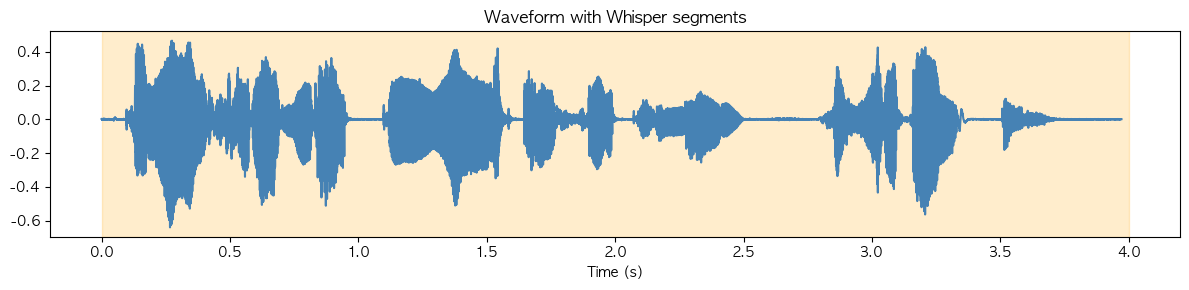

In [32]:
# 예시: 오디오 파형 + 전사 세그먼트 시각화
wav, sr = load_audio_mono_16k(EXAMPLE_WAV, duration_sec=15)
out = transcribe_with_whisper('./data/speech/tmp_16k.wav', model_name='base', language='ko')

plot_wave_and_segments(wav, sr, out.get('segments', []))